# Examples on Information Processinig Capacity visualizations
A notebook for demonstrating the IPC tools in this repository, demonstrated for a random ESN network.

## Imports
and helper functions


In [21]:
from utils import createNARMAFromInput
import numpy as np
from simulator import NetworkSimulator
import Capacities.capacities as CAP
import matplotlib.pyplot as plt
import seaborn as sns
from examples.visual_example import get_example_networks
from reservoirpy.datasets import mackey_glass
from utils import autocorrelation

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=2.9, palette='deep', context='paper', rc=custom_params)

def cap2vec(capacities,maxdel=1000,maxdeg=10):
    vec = np.zeros((maxdel,maxdeg))
    for idx in range(len(capacities)):
        delay=capacities[idx]['delay']
        degree=capacities[idx]['degree']
        if (delay<=maxdel) and (degree<=maxdeg):
            vec[delay-1,degree-1]+=capacities[idx]['score']
    return vec

def cap2mat(capacities,maxdel=1000,maxdeg=10,maxwin=10):
    vec = np.zeros((maxdel,maxwin,maxdeg))
    for idx in range(len(capacities)):
        delay=capacities[idx]['delay']
        degree=capacities[idx]['degree']
        win=capacities[idx]['window']
        if (delay<=maxdel) and (degree<=maxdeg) and (win<=maxwin):
            vec[delay-1, win-1, degree-1]+=capacities[idx]['score']
    return vec

# seed for reproducibility
np.random.seed(6)

## Generate Network
First we generate a random ESN

In [22]:
# N = 300
# k = 1
# x_lim = [-1, 1]
# y_lim = [-1, 1]
# net_params = params_start_evolution(N, dt=1, k=k, x_lim=x_lim, y_lim=y_lim)
# start_net = populations.GMMPopulation(**net_params)

opt_path = "NARMA-30_results_23/NARMA30_old_bl_results_n101_k4_date_2024-03-18.p"

random_network, optimized_network = get_example_networks(opt_path)
start_net = random_network

dict_keys(['validation performance', 'parameters', 'evolutionary strategy', 'cma stds', 'example net', 'train data', 'validation data'])


Next, some random i.i.d. input is given and reservoir states are recorded. Make sure to use valid input distribution. For Legendre Polynomial basis functions, uniform input between -1 and 1

In [23]:
sim = NetworkSimulator(start_net)
warmup = 100
n_samples = 10000
data_in = np.random.uniform(-1, 1, (n_samples + warmup,))
net_states = sim.get_network_data(data_in)
print(net_states.shape)
data_in = data_in[warmup:]
net_states = net_states[:, warmup:]

(100, 10100)


## Compute IPC
We compute an IPC landscape based on reservoir activity and corresponding inputs

In [24]:
# Define IPC search space
max_lag = 40
max_degree = 3
max_window = 30
params = {
    'mindel': 1,
    'mindeg': 1,
    'maxdel': max_lag,
    'maxdeg': max_degree,
    'minvars': 1,
    'maxvars': 3,
    'minwindow': 0,
    'maxwindow': max_window,
    'm_delay': False,
    'm_degrees': False,
    'm_window': False,
    'm_windowpos': False,
    'm_variables': False
}

Citer=CAP.capacity_iterator(**params)#, verbose = 1)
totalcap, allcaps, numcaps, nodes = Citer.collect(data_in, net_states.T)

Estimated rank of state covariance matrix =  100
Total score for degree  1  =  21.88841873024974 (cumulative total =  21.88841873024974 )
Total score for degree  2  =  70.95559205292932 (cumulative total =  92.8440107831791 )
Total score for degree  3  =  6.97463232279379 (cumulative total =  99.81864310597284 )
Total capacity=99.819 (99.82 percent)


## Basic plot as function of lag
IPC for each degree plotted only as a function of lag, disregarding window size and number of variables.

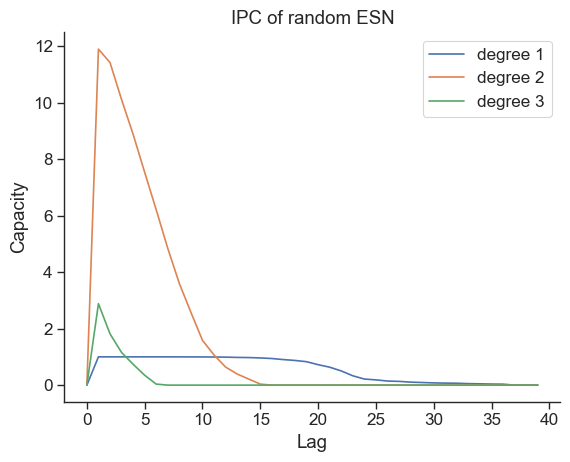

In [25]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=1.4, palette='deep', context='paper', rc=custom_params)
V = cap2vec(allcaps, maxdel = max_lag, maxdeg = max_degree)
plt.figure()
plt.plot(V)
plt.title('IPC of random ESN')
plt.legend(['degree ' + str(i+1) for i in range(max_degree)])
plt.ylabel('Capacity')
plt.xlabel('Lag')
plt.savefig('figs_output/example_IPC.pdf')

## Surface plots

(40, 30, 3)


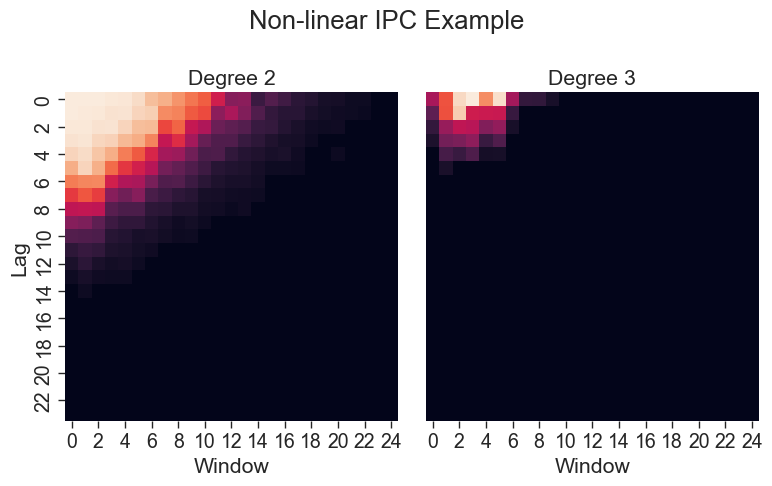

In [26]:
M = cap2mat(allcaps, maxdel = max_lag, maxdeg = max_degree, maxwin=30)

sns.set_theme(style="ticks", font_scale=1.6, palette='deep', context='paper')

fig, ax = plt.subplots(1, 2, figsize=(8,5), gridspec_kw={'width_ratios': [1, 1]})

print(M.shape)
sns.heatmap(M[1:25, :25, 1], ax=ax[0], cbar=False)
sns.heatmap(M[1:25, :25, 2], ax=ax[1], cbar=False, yticklabels=False)
# sns.heatmap(M[:, :, 3], ax=ax[2], cbar=False, yticklabels=False)
ax[0].set_ylabel('Lag')
ax[0].set_xlabel('Window')
ax[1].set_xlabel('Window')
# ax[2].set_xlabel('Window')
ax[0].set_title('Degree 2')
ax[1].set_title('Degree 3')
# ax[2].set_title('Degree 4')
fig.suptitle('Non-linear IPC Example')
plt.tight_layout()
plt.savefig('figs_output/example_IPC_window.pdf')

# Task Capacity example
Besides IPC for reservoirs, we can simply substitute the task system itself.

Here we generate task data using the same inputs as above, and compute the task capacity

In [7]:
# Create task output
narma_in = (data_in + 1) / 4
narma_out = createNARMAFromInput(narma_in)

data_in = np.array(data_in)
narma_out = np.array(narma_out)

# Define IPC search space
max_lag = 50
max_degree = 3
max_window = 32
params = {
    'mindel': 1,
    'mindeg': 1,
    'maxdel': max_lag,
    'maxdeg': max_degree,
    'minvars': 1,
    'maxvars': 4,
    'minwindow': 0,
    'maxwindow': max_window,
    'm_delay': False,
    'm_degrees': False,
    'm_window': False,
    'm_windowpos': False,
    'm_variables': False
}

Citer=CAP.capacity_iterator(**params)#, verbose = 1)
totalcap_task, allcaps_task, numcaps_task, nodes_task = Citer.collect(data_in, narma_out)

Total score for degree  1  =  0.851398272175576 (cumulative total =  0.851398272175576 )
Total score for degree  2  =  0.10216611276774262 (cumulative total =  0.9535643849433185 )
Total score for degree  3  =  0.0 (cumulative total =  0.9535643849433185 )
Total capacity=0.954 (95.36 percent)


Text(0.5, 0, 'Lag')

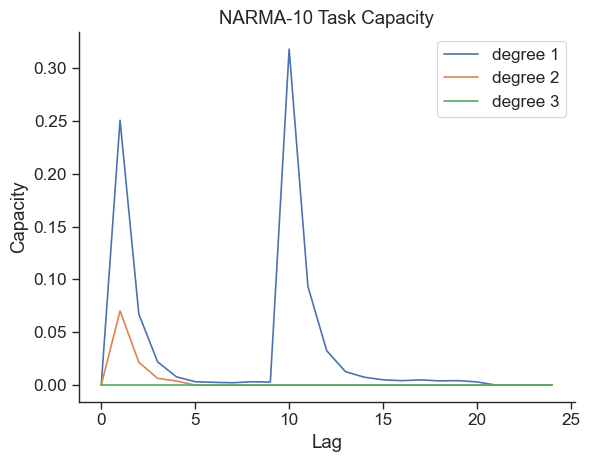

In [16]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=1.4, palette='deep', context='paper', rc=custom_params)
V = cap2vec(allcaps_task, maxdel = max_lag, maxdeg = max_degree)
plt.figure()
plt.plot(V[:25])
plt.title('NARMA-10 Task Capacity')
plt.legend(['degree ' + str(i+1) for i in range(max_degree)])
plt.ylabel('Capacity')
plt.xlabel('Lag')
# plt.savefig('figs_output/example_IPC.pdf')

Text(0.5, 1.0, 'NARMA-10 Second degree Task Capacity')

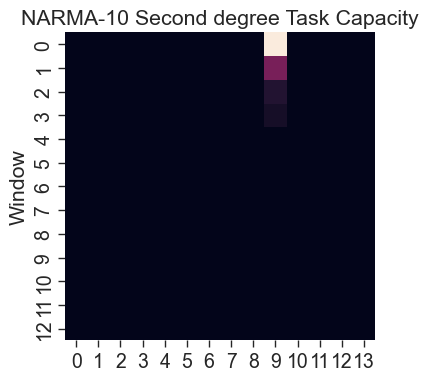

In [21]:
M = cap2mat(allcaps_task, maxdel = max_lag, maxdeg = max_degree, maxwin=30)

sns.set_theme(style="ticks", font_scale=1.6, palette='deep', context='paper')
plt.figure(figsize=(4,4))
sns.heatmap(M[1:14, :14, 1], cbar=False)
plt.ylabel('Lag')
plt.ylabel('Window')
plt.title("NARMA-10 Second degree Task Capacity")

# IPC and dataset size
let's see how task capacity accuracy depends on dataset size.

First, we compute the capacities for different data set sizes

In [39]:
# Define IPC search space
max_lag = 40
max_degree = 3
max_window = 30
params = {
    'mindel': 1,
    'mindeg': 1,
    'maxdel': max_lag,
    'maxdeg': max_degree,
    'minvars': 1,
    'maxvars': 3,
    'minwindow': 0,
    'maxwindow': max_window,
    'm_delay': False,
    'm_degrees': False,
    'm_window': False,
    'm_windowpos': False,
    'm_variables': False
}

Citer=CAP.capacity_iterator(**params)

set_sizes = [(i+1) * 1000 for i in range(10)]
caps_per_size = {}
for size in set_sizes:
    partial_in = data_in[:size]
    partial_net_act = net_states[:, :size]
    totalcap, allcaps, numcaps, nodes = Citer.collect(partial_in, partial_net_act.T)
    caps_per_size[size] = allcaps

Estimated rank of state covariance matrix =  100
Total score for degree  1  =  20.992074201792793 (cumulative total =  20.992074201792793 )
Total score for degree  2  =  68.29532999953963 (cumulative total =  89.28740420133248 )
Total score for degree  3  =  0.9885280724100379 (cumulative total =  90.27593227374251 )
Total capacity=90.276 (90.28 percent)
Estimated rank of state covariance matrix =  100
Total score for degree  1  =  21.690201651689755 (cumulative total =  21.690201651689755 )
Total score for degree  2  =  70.17137983328294 (cumulative total =  91.86158148497269 )
Total score for degree  3  =  3.45792088922558 (cumulative total =  95.31950237419828 )
Total capacity=95.320 (95.32 percent)
Estimated rank of state covariance matrix =  100
Total score for degree  1  =  21.71310882386594 (cumulative total =  21.71310882386594 )
Total score for degree  2  =  71.2203171527399 (cumulative total =  92.93342597660583 )
Total score for degree  3  =  5.080817517972317 (cumulative to

# Experimenting with non i.i.d. inputs
MC and IPC assume i.i.d. input data. While a reservoir can always be driven with any input desired, in the case of task capacity for some tasks this is different. Signal generation tasks that are not input driven can be considered to provide their own input, but this has inherent autocorrelations. In the following cells, we explore what happens if we compute IPC in such cases, with the Mackey-Glass system as an example

## Autocorrelation
First, we have a look at the MG autocorrelation, which could be considered the linear TC.

(10000, 1)


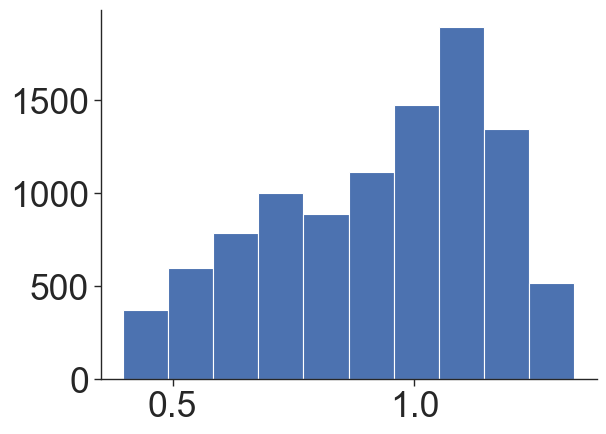

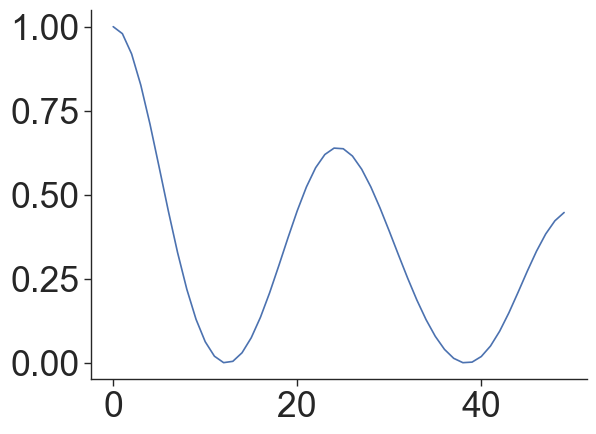

In [5]:
mg_data = mackey_glass(10000)
print(mg_data.shape)
plt.figure()
plt.hist(mg_data)
mg_ac = autocorrelation(mg_data, 50)
mg_ac = np.array(mg_ac)**2
plt.figure()
plt.plot(mg_ac)

Now let's try IPC TC

In [17]:
# Create task output, at least try and roughly scale it to the preferred ranges
data_in = (mg_data - np.mean(mg_data))/(2 * np.std(mg_data))
data_in = data_in[400:]

# Define IPC search space
max_lag = 50
max_degree = 3
max_window = 32
params = {
    'mindel': 1,
    'mindeg': 1,
    'maxdel': max_lag,
    'maxdeg': max_degree,
    'minvars': 1,
    'maxvars': 4,
    'minwindow': 0,
    'maxwindow': max_window,
    'm_delay': False,
    'm_degrees': False,
    'm_window': False,
    'm_windowpos': False,
    'm_variables': False
}

Citer=CAP.capacity_iterator(**params)#, verbose = 1)
totalcap_task, allcaps_task, numcaps_task, nodes_task = Citer.collect(data_in, data_in)

Total score for degree  1  =  16.860622772037793 (cumulative total =  16.860622772037793 )
Total score for degree  2  =  42.71384672058663 (cumulative total =  59.57446949262445 )
Total score for degree  3  =  2261.110817958667 (cumulative total =  2320.6852874512883 )
Total capacity=2320.685 (232068.53 percent)


Text(0.5, 0, 'Lag')

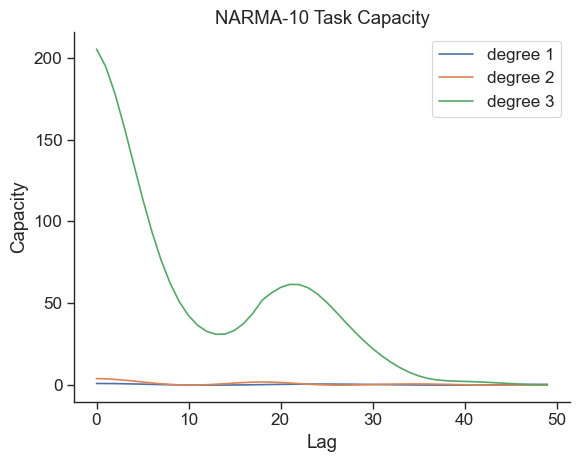

In [18]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=1.4, palette='deep', context='paper', rc=custom_params)
V = cap2vec(allcaps_task, maxdel = max_lag, maxdeg = max_degree)
plt.figure()
plt.plot(V)
plt.title('NARMA-10 Task Capacity')
plt.legend(['degree ' + str(i+1) for i in range(max_degree)])
plt.ylabel('Capacity')
plt.xlabel('Lag')
# plt.savefig('figs_output/example_IPC.pdf')

(50, 30, 3)


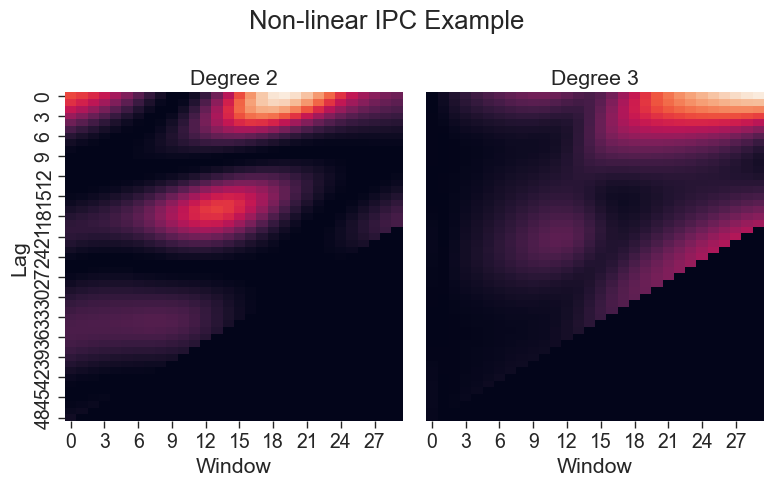

In [20]:
M = cap2mat(allcaps_task, maxdel = max_lag, maxdeg = max_degree, maxwin=30)

sns.set_theme(style="ticks", font_scale=1.6, palette='deep', context='paper')

fig, ax = plt.subplots(1, 2, figsize=(8,5), gridspec_kw={'width_ratios': [1, 1]})

print(M.shape)
sns.heatmap(M[1:, :, 1], ax=ax[0], cbar=False)
sns.heatmap(M[1:, :, 2], ax=ax[1], cbar=False, yticklabels=False)
# sns.heatmap(M[:, :, 3], ax=ax[2], cbar=False, yticklabels=False)
ax[0].set_ylabel('Lag')
ax[0].set_xlabel('Window')
ax[1].set_xlabel('Window')
# ax[2].set_xlabel('Window')
ax[0].set_title('Degree 2')
ax[1].set_title('Degree 3')
# ax[2].set_title('Degree 4')
fig.suptitle('Non-linear IPC Example')
plt.tight_layout()
# plt.savefig('figs_output/example_IPC_window.pdf')